# **작사가 인공지능 만들기**

## Import

In [7]:
import os, re
import glob
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

## 데이터 로드

In [8]:
from google.colab import drive
drive.mount('/content/drive')

txt_file_path = '/content/drive/MyDrive/song_lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
  with open(txt_file, "r") as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


## 데이터 전처리

In [9]:
import re            
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

In [10]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 '<start> baby , can t you read the signs ? i won t bore you with the details , baby <end>',
 '<start> i don t even wanna waste your time <end>',
 '<start> let s just say that maybe <end>',
 '<start> you could help me ease my mind <end>',
 '<start> i ain t mr . right but if you re looking for fast love <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>']

In [11]:
import tensorflow as tf
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   
    # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer
tensor, tokenizer = tokenize(corpus)

[[  2 304  28 ...   0   0   0]
 [  2 221  13 ...   0   0   0]
 [  2  24  17 ...   0   0   0]
 ...
 [  2  23  77 ...   0   0   0]
 [  2  42  26 ...   0   0   0]
 [  2  23  77 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fa2874e9110>


In [12]:
print(tensor[:3, :15])

[[   2  304   28   99 4811    3    0    0    0    0    0    0    0    0
     0]
 [   2  221   13   85  226    6  115    3    0    0    0    0    0    0
     0]
 [   2   24   17 1087 2347    3    0    0    0    0    0    0    0    0
     0]]


In [13]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [14]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2  304   28   99 4811    3    0    0    0    0    0    0    0    0]
[ 304   28   99 4811    3    0    0    0    0    0    0    0    0    0]


## 데이터 분리

In [15]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [16]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   
# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

In [18]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

## 인공지능 만들기

In [19]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [20]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.92801726e-05,  2.52481666e-04, -9.05677825e-06, ...,
         -1.81187992e-04,  1.70216790e-05,  5.97220642e-05],
        [ 2.49573000e-04,  8.88009265e-04,  6.58562130e-05, ...,
         -2.79486179e-04, -3.66899825e-04,  1.47413652e-04],
        [ 2.70607910e-04,  6.75287447e-04,  4.87733079e-04, ...,
         -6.47639506e-04, -1.83382755e-04,  1.85216893e-04],
        ...,
        [ 9.90981469e-04, -4.07961867e-04,  1.50683883e-03, ...,
         -5.89087140e-04, -2.77537270e-03, -8.54093872e-04],
        [ 8.22295551e-04, -3.08509945e-04,  1.83165830e-03, ...,
         -4.75098001e-04, -3.09050130e-03, -4.61841788e-04],
        [ 6.12636737e-04, -4.58087510e-04,  2.09724251e-03, ...,
         -5.97781618e-04, -3.40058748e-03, -1.19967284e-04]],

       [[ 3.03862995e-04,  2.10665967e-04,  1.95092907e-05, ...,
          1.14510149e-04, -9.21122773e-06, -2.66728108e-04],
        [ 1.94629683e-04,  2.55815568e-04,  1

In [21]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  12289024  
                                                                 
 lstm (LSTM)                 multiple                  25174016  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  24590049  
                                                                 
Total params: 95,615,713
Trainable params: 95,615,713
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [23]:
history = []
epochs = 10
history = model.fit(dataset,
          epochs=epochs,
          batch_size=256,
          validation_data=val_dataset,
          verbose=1)

Epoch 1/10
549/549 [==============================] - 303s 547ms/step - loss: 3.4276 - accuracy: 0.4720 - val_loss: 3.0400 - val_accuracy: 0.5020
Epoch 2/10
549/549 [==============================] - 307s 560ms/step - loss: 2.8501 - accuracy: 0.5154 - val_loss: 2.7726 - val_accuracy: 0.5259
Epoch 3/10
549/549 [==============================] - 307s 559ms/step - loss: 2.5244 - accuracy: 0.5455 - val_loss: 2.5906 - val_accuracy: 0.5513
Epoch 4/10
549/549 [==============================] - 308s 561ms/step - loss: 2.2273 - accuracy: 0.5800 - val_loss: 2.4629 - val_accuracy: 0.5728
Epoch 5/10
549/549 [==============================] - 308s 561ms/step - loss: 1.9603 - accuracy: 0.6175 - val_loss: 2.3781 - val_accuracy: 0.5914
Epoch 6/10
549/549 [==============================] - 308s 560ms/step - loss: 1.7271 - accuracy: 0.6558 - val_loss: 2.3227 - val_accuracy: 0.6075
Epoch 7/10
549/549 [==============================] - 308s 561ms/step - loss: 1.5322 - accuracy: 0.6912 - val_loss: 2.2925 -

In [24]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

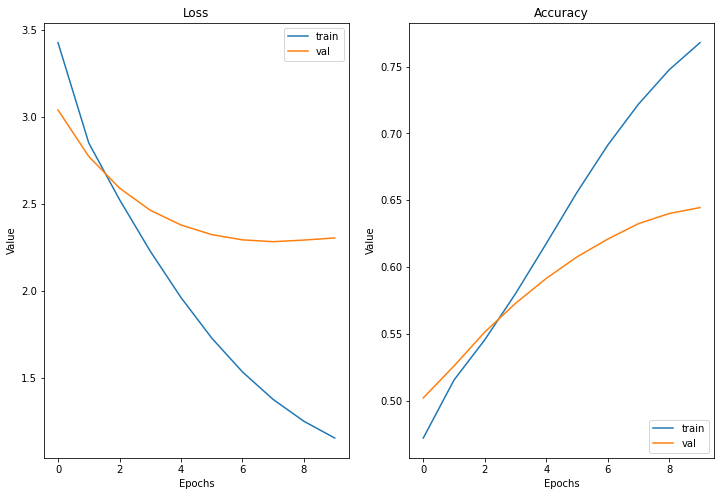

In [25]:
import matplotlib.pyplot as plt 
plot_curve(history.epoch, history.history,
           ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [26]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

## 가사

In [30]:
generate_text(model, tokenizer, init_sentence="<start> i was", max_len=20)

'<start> i was born to make you happy <end> '

가사가 너무 낭만적이라 깜짝 놀랐다.

In [33]:
generate_text(model, tokenizer, init_sentence="<start> how did", max_len=20)

'<start> how did you get to sweden ? <end> '

In [29]:
generate_text(model, tokenizer, init_sentence="<start> he", max_len=20)

'<start> he s lookin for that home , and i hope he finds it <end> '

## **Summary**


작사가 인공지능을 만들기 위해, 데이터 전처리부터 토크나이즈,

트레이닝 후 테스트까지 완료했다.

validation loss를 줄이기 위해 dropout 값을 조정하였고, 원하는 결과를 얻을 수 있었다.

모델을 이것 저것 뜯어고쳐보고 싶었지만, 에포크 단계에서 시간이 많이 소요되어,

생각보다 많은 수정을 할 수가 없었다.

하지만, 결과적으로 그럴 듯한 가사를 얻을 수 있었다.

이번 프로젝트를 통해 자연어 처리에 대해 더 흥미가 생기는 계기가 되었다.


